## Face mask detection using yolo-v5

### This python notebooks shows how to train an yolo-v5 model to detect face masks

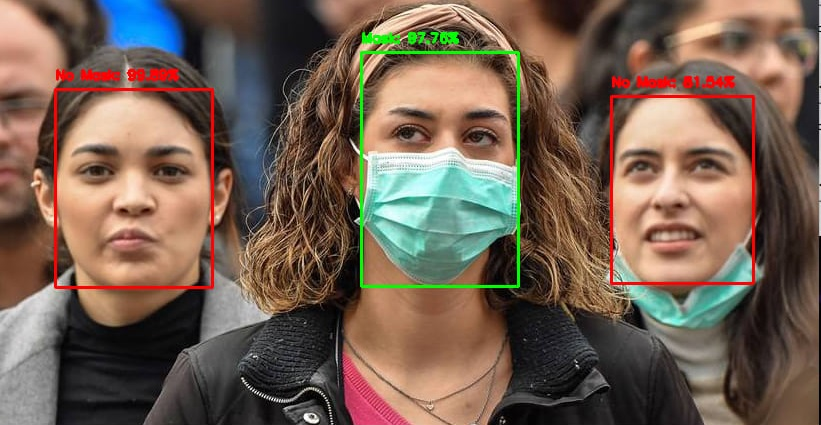

###ABout the dataset: The annotated data of faces with and with out mask can be downloaded
https://www.kaggle.com/techzizou/labeled-mask-dataset-yolo-darknet

The dataset has individual images and the corresponding boudning box detail for each file in txt format

## Steps
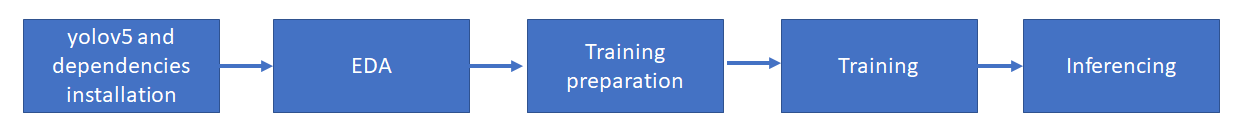

In [1]:
from google.colab import drive
import os
import zipfile
import urllib3
import numpy as np
import cv2
import shutil
import random
import matplotlib.pyplot as plt
import pandas as pd



In [47]:
MOUNT='/content/drive/'
PROJECT_PATH = "/content/drive/My Drive/face_mask_detection"
ZIP_FILE_NAME='archive.zip'
DATA_FOLDER='face_mask_data'
URL='https://www.kaggle.com/techzizou/labeled-mask-dataset-yolo-darknet/download'
IMAGE_FILE_EXTENSION='.jpg'
ANNOT_FILE_EXTENSION='.txt'
TEST_SIZE=100
VALIDATION_SIZE=300
NO_OF_CLASSES=2
NAMES =['MASK', 'NO MASK']
YAML_FILE='mask_detection.yaml'
PERFORMANCE_FILE_LOC="yolov5/runs/train/exp"

In [3]:
drive.mount(MOUNT)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
os.chdir(PROJECT_PATH)

Check the GPU allocated 

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec 14 07:48:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

install the OIDV4 toolkit. clone from git

In [108]:
!git clone https://github.com/EscVM/OIDv4_ToolKit.git

Cloning into 'OIDv4_ToolKit'...
remote: Enumerating objects: 422, done.
remote: Total 422 (delta 0), reused 0 (delta 0), pack-reused 422
Receiving objects: 100% (422/422), 34.08 MiB | 16.02 MiB/s, done.
Resolving deltas: 100% (146/146), done.


In [109]:
!pip3 install -r OIDv4_ToolKit/requirements.txt

     |████████████████████████████████| 3.8 MB 7.7 MB/s 
     |████████████████████████████████| 8.4 MB 26.4 MB/s 
     |████████████████████████████████| 79 kB 8.1 MB/s 
     |████████████████████████████████| 547 kB 50.3 MB/s 
     |████████████████████████████████| 138 kB 52.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: rsa
    Found existing installation: rsa 4.8
    Uninstalling rsa-4.8:
      Successfully uninstalled rsa-4.8
  Attempting uninstall: docutils
    Found existing installation: docutils 0.17.1
    Uninstalling docutils-0.17.1:
      Successfully uninstalled docutils-0.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have url

In [7]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 10200, done.
remote: Total 10200 (delta 0), reused 0 (delta 0), pack-reused 10200
Receiving objects: 100% (10200/10200), 10.46 MiB | 7.17 MiB/s, done.
Resolving deltas: 100% (7065/7065), done.


In [8]:
!pip install -U -r yolov5/requirements.txt

     |████████████████████████████████| 11.2 MB 8.4 MB/s 
     |████████████████████████████████| 15.7 MB 39.7 MB/s 
     |████████████████████████████████| 60.3 MB 1.6 MB/s 
     |████████████████████████████████| 3.1 MB 33.1 MB/s 
     |████████████████████████████████| 596 kB 47.4 MB/s 
     |████████████████████████████████| 62 kB 866 kB/s 
     |████████████████████████████████| 38.1 MB 1.5 MB/s 
     |████████████████████████████████| 11.3 MB 39.0 MB/s 
     |████████████████████████████████| 884 kB 51.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting

#Extract the files in Zip file and split the data into Train-validation-test sample

In [ ]:
with zipfile.ZipFile(ZIP_FILE_NAME, "r") as z:
    z.extractall(PROJECT_PATH+"/"+DATA_FOLDER)

In [ ]:
!ls

 archive.zip	  face_mask_detection_model.ipynb   yolov5
 face_mask_data   OIDv4_ToolKit			   'yolov5_mask detection'


###Create train, validation and test folders and transfer the samples to the corresponding folders

In [76]:
os.mkdir (DATA_FOLDER+"/"+'train')
os.mkdir(DATA_FOLDER+"/"+'validation')
os.mkdir(DATA_FOLDER+"/"+'test')

In [6]:
file_names=[]
for file in os.listdir(DATA_FOLDER+"/obj"):
    if file.endswith(IMAGE_FILE_EXTENSION):
      file_names.append(file)
print (len(file_names), " images found")

1510  images found


In [12]:
print (file_names)

['unmasked (1384).jpg', 'unmasked (1385).jpg', 'unmasked (1386).jpg', 'unmasked (1387).jpg', 'unmasked (1388).jpg', 'unmasked (1389).jpg', 'unmasked (1390).jpg', 'unmasked (1391).jpg', 'unmasked (1392).jpg', 'unmasked (1393).jpg', 'unmasked (1394).jpg', 'unmasked (1395).jpg', 'unmasked (1396).jpg', 'unmasked (1397).jpg', 'unmasked (1398).jpg', 'unmasked (1399).jpg', 'unmasked (1400).jpg', 'unmasked (1401).jpg', 'unmasked (1402).jpg', 'unmasked (1403).jpg', 'unmasked (1404).jpg', 'unmasked (1405).jpg', 'unmasked (1406).jpg', 'unmasked (1407).jpg', 'unmasked (1408).jpg', 'unmasked (1409).jpg', 'unmasked (1410).jpg', 'unmasked (1411).jpg', 'unmasked (1412).jpg', 'unmasked (1413).jpg', 'unmasked (1414).jpg', 'unmasked (1415).jpg', 'unmasked (1416).jpg', 'unmasked (1417).jpg', 'unmasked (1418).jpg', 'unmasked (1419).jpg', 'unmasked (1420).jpg', 'unmasked (1421).jpg', 'unmasked (1422).jpg', 'unmasked (1424).jpg', 'unmasked (1425).jpg', 'unmasked (1426).jpg', 'unmasked (1427).jpg', 'unmasked 

In [7]:
def masked_condition(file):
  #masked_condition='with-mask' in file or 'with_mask' in file or 'with_maska' in file or 'with_maskb' in file or 'masked' in file and not 'unmasked' in file or 'pra' in file
  file_exts=['with-mask','with_mask','with_maska','with_maskb','masked','pra']
  msk_condition=False
  for cond in file_exts:
    msk_condition= msk_condition or cond in file
  msk_condition=msk_condition and not 'unmasked' in file
  return (msk_condition)

In [8]:
index=0
masked=[]
unmasked=[]
target=np.zeros(len(file_names),dtype=int)
for file in file_names:
  if masked_condition(file):
    masked.append(file)
    target[index]=1
  else:
    unmasked.append(file)
  index+=1

In [9]:
print (len(masked), 'images have masks')
print (len(unmasked), 'images do not have masks')
imb=round(100*len(masked)/len(file_names))
print ('imbalance level-> mask:unmasked :: ', imb, ":", 100-imb)

1049 images have masks
461 images do not have masks
imbalance level-> mask:unmasked ::  69 : 31


In [10]:
print (masked)

['with_mask (1).jpg', 'with_mask (10).jpg', 'with_mask (100).jpg', 'with_mask (101).jpg', 'with_mask (102).jpg', 'with_mask (103).jpg', 'with_mask (104).jpg', 'with_mask (105).jpg', 'with_mask (11).jpg', 'with_mask (12).jpg', 'with_mask (13).jpg', 'with_mask (14).jpg', 'with_mask (15).jpg', 'with_mask (16).jpg', 'with_mask (17).jpg', 'with_mask (18).jpg', 'with_mask (19).jpg', 'with_mask (2).jpg', 'with_mask (20).jpg', 'with_mask (21).jpg', 'with_mask (22).jpg', 'with_mask (23).jpg', 'with_mask (24).jpg', 'with_mask (25).jpg', 'with_mask (26).jpg', 'with_mask (27).jpg', 'with_mask (28).jpg', 'with_mask (29).jpg', 'with_mask (3).jpg', 'with_mask (30).jpg', 'with_mask (31).jpg', 'with_mask (32).jpg', 'with_mask (33).jpg', 'with_mask (34).jpg', 'with_mask (35).jpg', 'with_mask (36).jpg', 'with_mask (37).jpg', 'with_mask (38).jpg', 'with_mask (39).jpg', 'with_mask (4).jpg', 'with_mask (40).jpg', 'with_mask (41).jpg', 'with_mask (42).jpg', 'with_mask (43).jpg', 'with_mask (44).jpg', 'with_m

In [11]:
print (unmasked)

['unmasked (1384).jpg', 'unmasked (1385).jpg', 'unmasked (1386).jpg', 'unmasked (1387).jpg', 'unmasked (1388).jpg', 'unmasked (1389).jpg', 'unmasked (1390).jpg', 'unmasked (1391).jpg', 'unmasked (1392).jpg', 'unmasked (1393).jpg', 'unmasked (1394).jpg', 'unmasked (1395).jpg', 'unmasked (1396).jpg', 'unmasked (1397).jpg', 'unmasked (1398).jpg', 'unmasked (1399).jpg', 'unmasked (1400).jpg', 'unmasked (1401).jpg', 'unmasked (1402).jpg', 'unmasked (1403).jpg', 'unmasked (1404).jpg', 'unmasked (1405).jpg', 'unmasked (1406).jpg', 'unmasked (1407).jpg', 'unmasked (1408).jpg', 'unmasked (1409).jpg', 'unmasked (1410).jpg', 'unmasked (1411).jpg', 'unmasked (1412).jpg', 'unmasked (1413).jpg', 'unmasked (1414).jpg', 'unmasked (1415).jpg', 'unmasked (1416).jpg', 'unmasked (1417).jpg', 'unmasked (1418).jpg', 'unmasked (1419).jpg', 'unmasked (1420).jpg', 'unmasked (1421).jpg', 'unmasked (1422).jpg', 'unmasked (1424).jpg', 'unmasked (1425).jpg', 'unmasked (1426).jpg', 'unmasked (1427).jpg', 'unmasked 

In [12]:
random.shuffle(masked)
random.shuffle(unmasked)

In [13]:
print (masked)

['383-with-mask.jpg', 'masked (1863).jpg', 'masked (1665).jpg', 'masked (1260).jpg', '262-with-mask.jpg', 'masked (1414).jpg', '182-with-mask.jpg', '406-with-mask.jpg', '174-with-mask.jpg', '47-with-mask.jpg', 'masked (1541).jpg', 'masked (1308).jpg', 'masked (1914).jpg', 'masked (1319).jpg', '394-with-mask.jpg', 'masked (1413).jpg', 'masked (1449).jpg', 'with_maska (16).jpg', '86-with-mask.jpg', 'masked (10).jpg', 'with_mask (61).jpg', 'masked (1911).jpg', 'masked (1384).jpg', 'masked (1599).jpg', 'masked (1591).jpg', 'masked (1328).jpg', '411-with-mask.jpg', 'with_maska (20).jpg', 'masked (1435).jpg', 'masked (1870).jpg', 'masked (1514).jpg', 'masked (1684).jpg', 'with_mask (33).jpg', 'masked (1656).jpg', 'with_mask (52).jpg', 'with_mask (83).jpg', 'with_maska (10).jpg', 'masked (1909).jpg', '106-with-mask.jpg', '456-with-mask.jpg', 'masked (1364).jpg', '307-with-mask.jpg', '326-with-mask.jpg', 'with_maskb (9).jpg', 'with_maska (24).jpg', 'masked (1263).jpg', 'masked (1643).jpg', 'ma

In [14]:
print (unmasked)

['unmasked (1511).jpg', 'unmasked (1406).jpg', 'unmasked (1454).jpg', 'unmasked (1549).jpg', 'unmasked (1491).jpg', 'unmasked (1459).jpg', 'unmasked (1514).jpg', 'unmasked (1342).jpg', 'unmasked (1741).jpg', '151.jpg', 'unmasked (1299).jpg', 'unmasked (1448).jpg', 'unmasked (1620).jpg', 'unmasked (1250).jpg', '159.jpg', 'unmasked (1476).jpg', 'unmasked (1582).jpg', 'unmasked (1592).jpg', 'unmasked (1399).jpg', 'unmasked (1481).jpg', 'unmasked (1293).jpg', 'unmasked (1858).jpg', 'unmasked (1383).jpg', 'unmasked (1714).jpg', 'unmasked (1307).jpg', 'unmasked (1425).jpg', 'unmasked (1314).jpg', 'unmasked (1597).jpg', 'unmasked (1563).jpg', 'unmasked (1538).jpg', 'unmasked (1653).jpg', 'unmasked (1567).jpg', 'unmasked (1477).jpg', 'unmasked (1551).jpg', 'unmasked (1566).jpg', 'unmasked (1498).jpg', 'unmasked (1418).jpg', 'unmasked (1330).jpg', 'unmasked (1458).jpg', 'unmasked (1555).jpg', 'unmasked (1659).jpg', 'unmasked (1560).jpg', 'unmasked (1421).jpg', 'unmasked (1388).jpg', 'unmasked (

In [15]:
val_count_unmsk =round(imb/100*VALIDATION_SIZE)
val_count_msk=VALIDATION_SIZE-val_count_unmsk
test_count_unmsk=round(imb/100*TEST_SIZE)+val_count_unmsk
test_count_msk=TEST_SIZE-test_count_unmsk+val_count_unmsk+val_count_msk

In [17]:
print ("Train samples")
print ("without mask files:[{}:{}]".format(test_count_unmsk,len(unmasked)))
print ("without mask files:[{}:{}]".format(test_count_msk,len(masked)))
print ('\n')
print ("Test samples")
print ("without mask files:[{}:{}]".format(val_count_unmsk,test_count_unmsk))
print ("with mask files:[{}:{}]".format(val_count_msk,test_count_msk))
print ('\n')
print ("Validation samples")
print ("without mask files:[{}:{}]".format(0,val_count_unmsk))
print ("with mask files:[{}:{}]".format(0,val_count_msk))


Train samples
without mask files:[276:461]
without mask files:[124:1049]


Test samples
without mask files:[207:276]
with mask files:[93:124]


Validation samples
without mask files:[0:207]
with mask files:[0:93]


In [18]:
val_files=unmasked[:val_count_unmsk]
val_files.extend(masked[:val_count_msk])
test_files=unmasked[val_count_unmsk:test_count_unmsk]
test_files.extend (masked[val_count_msk:test_count_msk])
train_files=unmasked[test_count_unmsk:]
train_files.extend (masked[test_count_msk:])

In [19]:

print (len(train_files), ' files set aside for training ')
print (len (val_files), ' files set aside for validation')
print (len (test_files), ' files set aside for final testing')

1110  files set aside for training 
300  files set aside for validation
100  files set aside for final testing


In [75]:
def copy_samples_folders(samples,folders):
  i=0
  print ("Copying files.......")
  for sample in samples:
    target=folders[i]
    print ("Copying files to ", target, "......")
    for file in sample:
      flname=file[:-4]
      img_file=flname+IMAGE_FILE_EXTENSION
      shutil.copy(DATA_FOLDER+'/obj/'+img_file, DATA_FOLDER+'/'+target+'/'+img_file)
      #print ('copied ',img_file)
      annot_flname= flname+ANNOT_FILE_EXTENSION
      shutil.copy(DATA_FOLDER+'/obj/'+annot_flname, DATA_FOLDER+'/'+target+'/'+annot_flname)
      #print ('copied ',annot_flname)
    i+=1
print ("Copied all the files")


Copied all the files


In [77]:
samples=[train_files,val_files,test_files ]
folders=['train','validation', 'test']
copy_samples_folders(samples,folders)

Copying files.......
Copying files to  train ......
Copying files to  validation ......
Copying files to  test ......


In [20]:
len(os.listdir('face_mask_data/train'))/2

1110.0

In [21]:
len(os.listdir('face_mask_data/validation'))/2

300.0

In [22]:
len(os.listdir('face_mask_data/test'))/2

100.0

In [23]:
df_images=pd.DataFrame( columns=['file', 'width','height', 'with mask'])

In [24]:
def get_img_size(files_list, location):
  height=[]
  width=[]
  for file in files_list:
    img=cv2.imread(location+file)
    h, w,_ = img.shape
    height.append(h)
    width.append(w)
  del img
  return (height, width)


In [25]:
height, width = get_img_size(file_names, location=DATA_FOLDER+'/obj/')

In [26]:
df_images['file']=file_names
df_images['width']=width
df_images['height']=height

In [27]:
df_images['with mask']= df_images['file'].apply (lambda x: 0 if x in unmasked else 1)

In [28]:
df_images.sample(20)

file  width  height  with mask
1146     26-with-mask.jpg    444     455          1
808     masked (1669).jpg    950     534          1
623     masked (1484).jpg    500     500          1
1283    413-with-mask.jpg    320     428          1
93    unmasked (1480).jpg    290     174          0
399    with_mask (48).jpg    980     552          1
306   unmasked (1794).jpg    320     433          0
844     masked (1864).jpg    275     183          1
226   unmasked (1617).jpg    183     275          0
739     masked (1600).jpg   1280     720          1
1350     49-with-mask.jpg    182     276          1
219   unmasked (1610).jpg    276     183          0
590     masked (1451).jpg   1300    1001          1
611     masked (1472).jpg   1000    1000          1
90    unmasked (1477).jpg    179     281          0
774     masked (1635).jpg   1200     800          1
825     masked (1687).jpg   1200     800          1
555     masked (1416).jpg    634     392          1
1304    435-with-mask.jpg    960     768          1
493    with_maskb (3).jpg    960     639          1

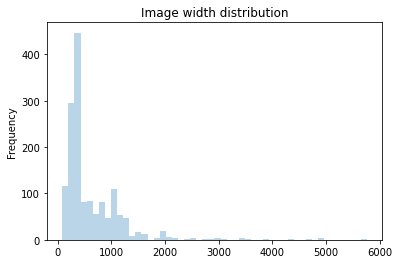

In [29]:
df_images['width'].plot.hist( bins= 50, alpha=0.3);
plt.title("Image width distribution");

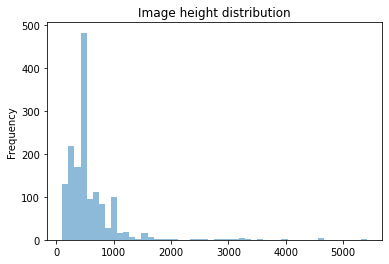

In [30]:
df_images['height'].plot.hist( bins= 50, alpha=0.5);
plt.title("Image height distribution");

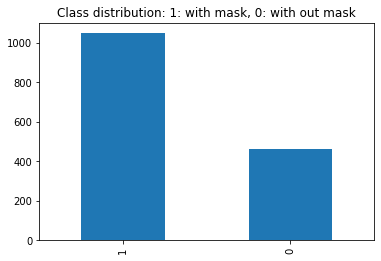

In [31]:
df_images['with mask'].value_counts().plot(kind ='bar');
plt.title("Class distribution: 1: with mask, 0: with out mask");

In [32]:
df_images[['width', 'height']].describe()

width       height
count  1510.000000  1510.000000
mean    613.530464   568.133113
std     561.755724   478.900608
min      89.000000   105.000000
25%     300.000000   340.000000
50%     327.000000   432.000000
75%     800.000000   675.000000
max    5760.000000  5412.000000

###setting scale to resize the images

In [33]:
FIG_SIZE=(613,570)

Display faces with and without mask

In [34]:
def display_images(img_file_list,location="", num_samples=10, resize=(500, 500)): # method to display a list of images in a row
  i=0
  files= [img_file_list[j] for j in random.sample(range(0, len(img_file_list)), num_samples)]
  f= plt.figure(figsize=(40,40)) 
  for file in files:
    img=cv2.imread(location+file)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    f.add_subplot(1, len(files), i + 1)
    plt.imshow(cv2.resize(img, resize))
    plt.axis('off')
    i+=1
  plt.show()

Displaying faces with mask


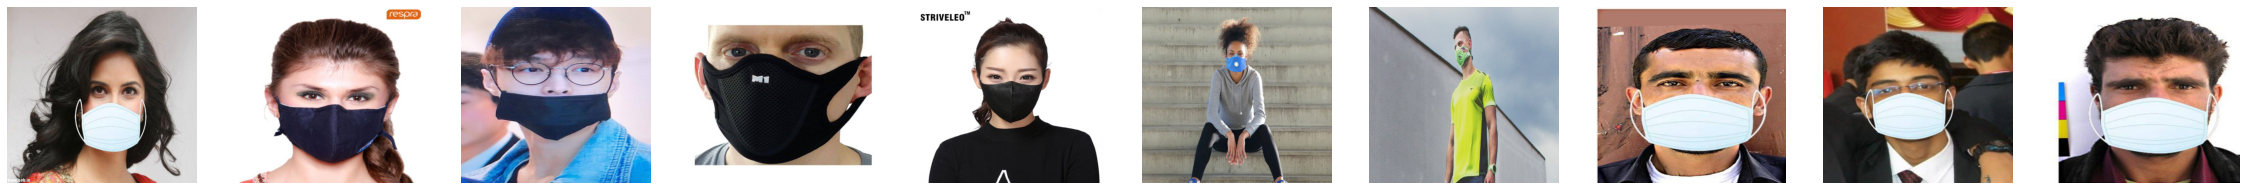

Displaying faces without mask


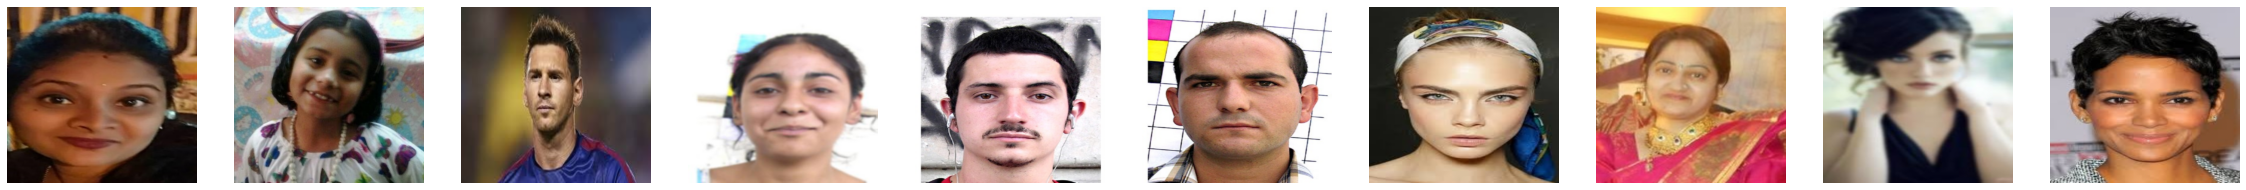

In [36]:
print ("Displaying faces with mask")
display_images(masked, location=DATA_FOLDER+'/obj/',resize=FIG_SIZE )
print ("Displaying faces without mask")
display_images(unmasked, location=DATA_FOLDER+'/obj/', resize=FIG_SIZE)

### prepare the yaml file with the label details

In [39]:
 yaml_lines=["train: " + PROJECT_PATH + "/"+ DATA_FOLDER +"/train", "val: " + PROJECT_PATH + "/"+ DATA_FOLDER +"/validation" , "test: " + PROJECT_PATH + "/"+ DATA_FOLDER +"/test", "nc: "+ str(NO_OF_CLASSES), "names: "+ str(NAMES)]

In [106]:
for line in yaml_lines:
  print (line)

train: /content/drive/My Drive/face_mask_detection/face_mask_data/train
val: /content/drive/My Drive/face_mask_detection/face_mask_data/validation
test: /content/drive/My Drive/face_mask_detection/face_mask_data/test
nc: 2
names: ['MASK', 'NO MASK']


In [43]:
f = open(YAML_FILE, "w")
for line in yaml_lines:
  print (line)
  f.write(line)
  f.write
f.close()

train: /content/drive/My Drive/face_mask_detection/face_mask_data/train
val: /content/drive/My Drive/face_mask_detection/face_mask_data/validation
test: /content/drive/My Drive/face_mask_detection/face_mask_data/test
nc: 2
names: ['MASK', 'NO MASK']


In [44]:
!ls

 archive.zip	  face_mask_detection_model.ipynb   robo.txt
 download	  mask_detection.yaml		    yolov5
 face_mask_data   OIDv4_ToolKit			   'yolov5_mask detection'


###Training the model

In [45]:
!python yolov5/train.py --img 416 --batch 16 --epochs 30 --data mask_detection.yaml --cfg yolov5/models/yolov5s.yaml

train: weights=yolov5/yolov5s.pt, cfg=yolov5/models/yolov5s.yaml, data=mask_detection.yaml, hyp=yolov5/data/hyps/hyp.scratch.yaml, epochs=30, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 2021-12-14 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=

### Model performance


The PR curve


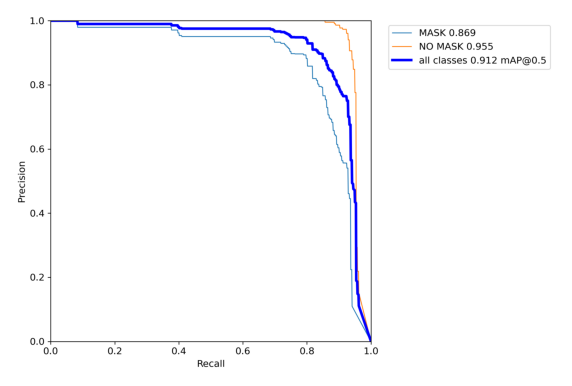

In [53]:
print ('The PR curve')
plt.figure(figsize=(10,10)) 
pr_curve_img=cv2.cvtColor(cv2.imread(PERFORMANCE_FILE_LOC+"/PR_curve.png"), cv2.COLOR_BGR2RGB)
plt.imshow(pr_curve_img);
plt.axis('off');

The Confusion matrix


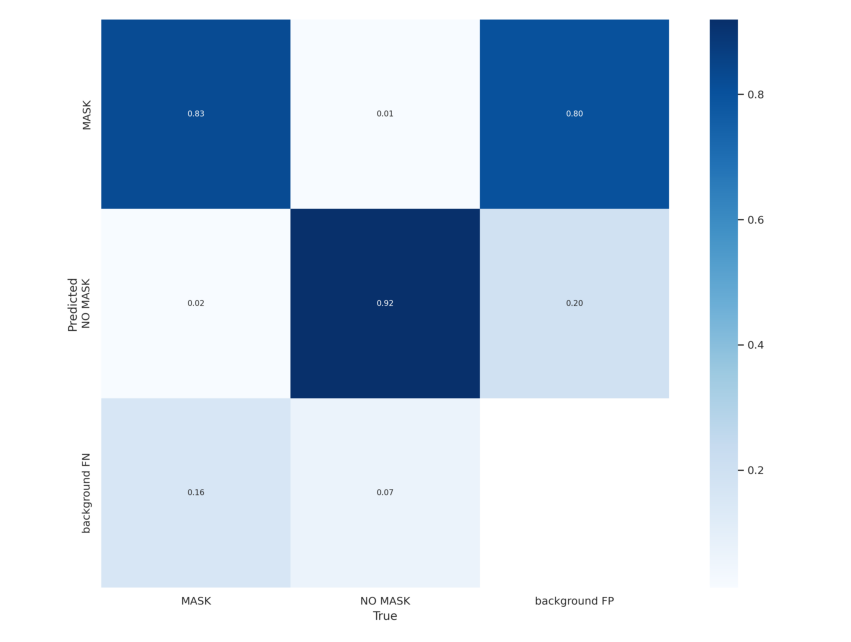

In [55]:
print ('The Confusion matrix')
plt.figure(figsize=(15,15)) 
pr_curve_img=cv2.cvtColor(cv2.imread(PERFORMANCE_FILE_LOC+"/confusion_matrix.png"), cv2.COLOR_BGR2RGB)
plt.imshow(pr_curve_img);
plt.axis('off');

Training details


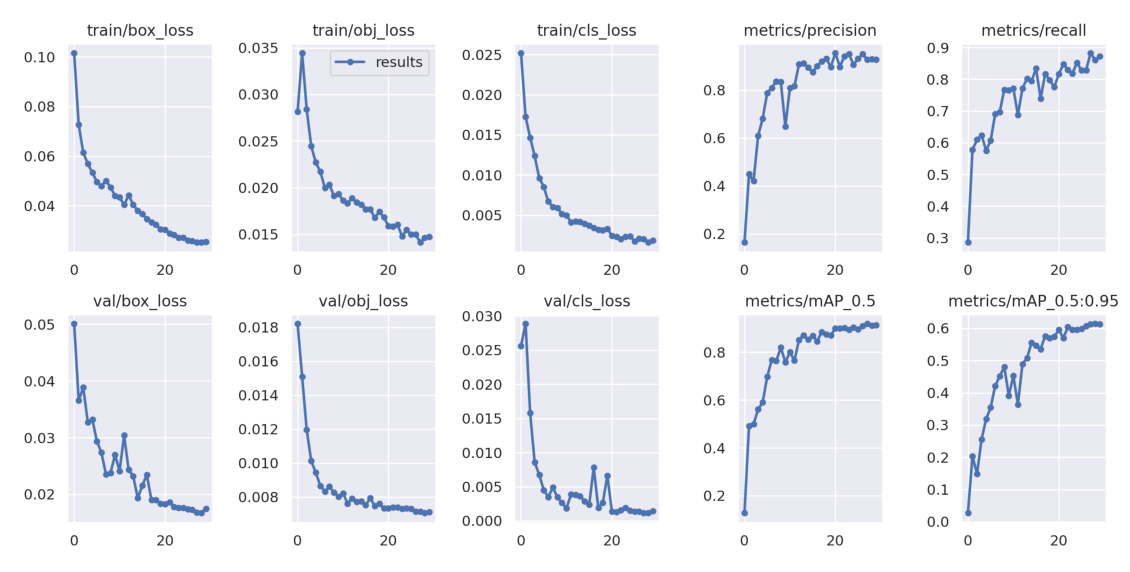

In [56]:
print ('Training details')
plt.figure(figsize=(20,20)) 
pr_curve_img=cv2.cvtColor(cv2.imread(PERFORMANCE_FILE_LOC+"/results.png"), cv2.COLOR_BGR2RGB)
plt.imshow(pr_curve_img);
plt.axis('off');

In [57]:
!python yolov5/detect.py --weights yolov5/runs/train/exp/weights/best.pt --img 416 --conf 0.5 --source face_mask_data/test 

detect: weights=['yolov5/runs/train/exp/weights/best.pt'], source=face_mask_data/test, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 2021-12-14 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/100 /content/drive/My Drive/face_mask_detection/face_mask_data/test/132.jpg: 320x416 1 NO MASK, Done. (0.015s)
image 2/100 /content/drive/My Drive/face_mask_detection/face_mask_data/test/151.jpg: 416x288 1 NO MASK, Done. (0.016s)
image 3/100 /content/drive/My Drive/face_mask_detection/face_mask_data/test/157-with-mask.jpg: 416x288 1 MASK, Done. (0.036s)
image 4/100 /con

### The inferencing takes about 13ms

In [78]:
location=PROJECT_PATH+'/yolov5/runs/detect/exp/'
results=[]
for files in os.listdir(location):
  if files.endswith(IMAGE_FILE_EXTENSION):
      results.append(files)
print (len(results), " images found")

100  images found


In [79]:
print (results)

['132.jpg', '151.jpg', '157-with-mask.jpg', '170-with-mask.jpg', '293-with-mask.jpg', '294-with-mask.jpg', '334-with-mask.jpg', '348-with-mask.jpg', '377-with-mask.jpg', '382-with-mask.jpg', '433-with-mask.jpg', '443-with-mask.jpg', '444-with-mask.jpg', '57-with-mask.jpg', '73-with-mask.jpg', 'masked (1270).jpg', 'masked (1283).jpg', 'masked (1387).jpg', 'masked (1417).jpg', 'masked (1427).jpg', 'masked (1572).jpg', 'masked (1584).jpg', 'masked (1601).jpg', 'masked (1621).jpg', 'masked (1873).jpg', 'masked (1900).jpg', 'masked (1904).jpg', 'unmasked (1265).jpg', 'unmasked (1267).jpg', 'unmasked (1270).jpg', 'unmasked (1286).jpg', 'unmasked (1302).jpg', 'unmasked (1309).jpg', 'unmasked (1313).jpg', 'unmasked (1334).jpg', 'unmasked (1335).jpg', 'unmasked (1337).jpg', 'unmasked (1376).jpg', 'unmasked (1390).jpg', 'unmasked (1396).jpg', 'unmasked (1410).jpg', 'unmasked (1426).jpg', 'unmasked (1432).jpg', 'unmasked (1437).jpg', 'unmasked (1439).jpg', 'unmasked (1445).jpg', 'unmasked (1448).

###Checking the output images

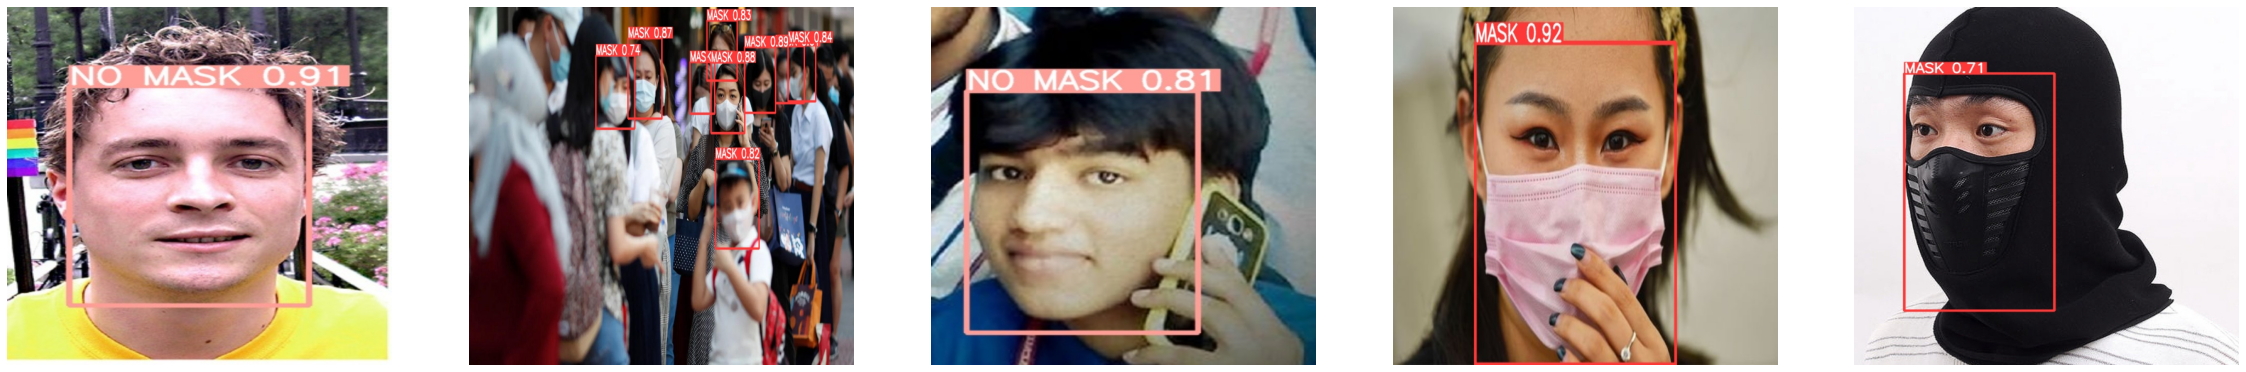

In [85]:

display_images(results, location=location, num_samples=5, resize=FIG_SIZE )

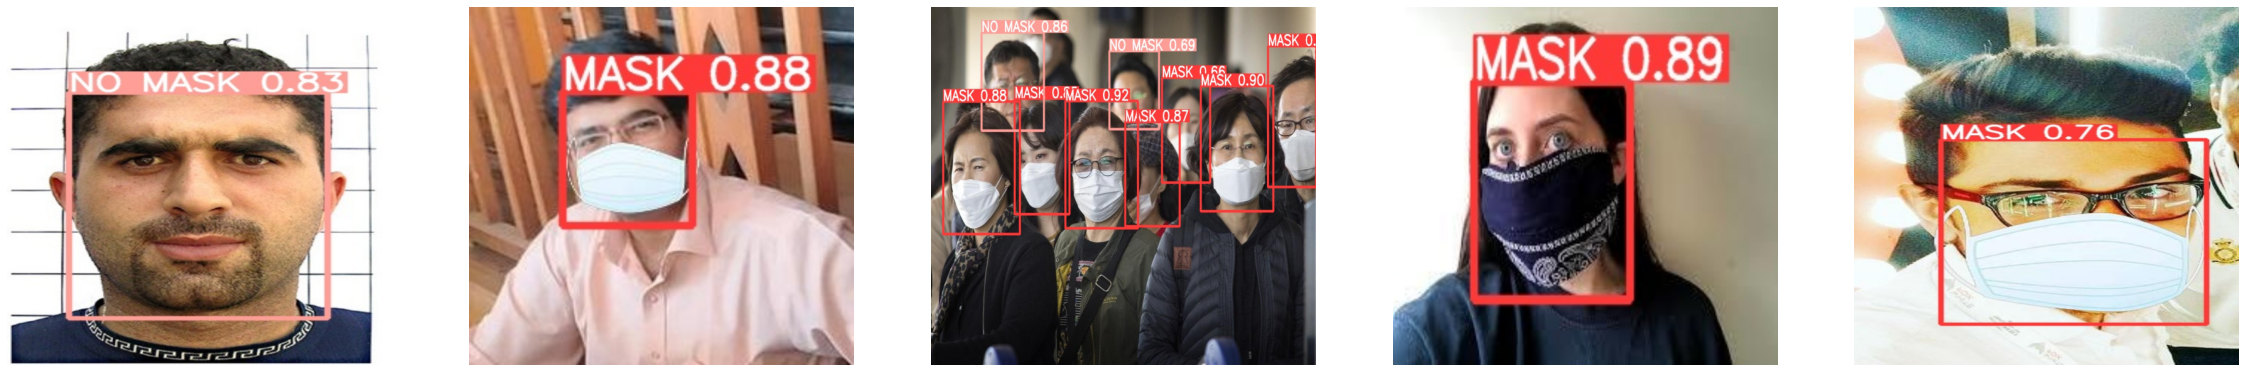

In [86]:
display_images(results, location=location, num_samples=5, resize=FIG_SIZE )

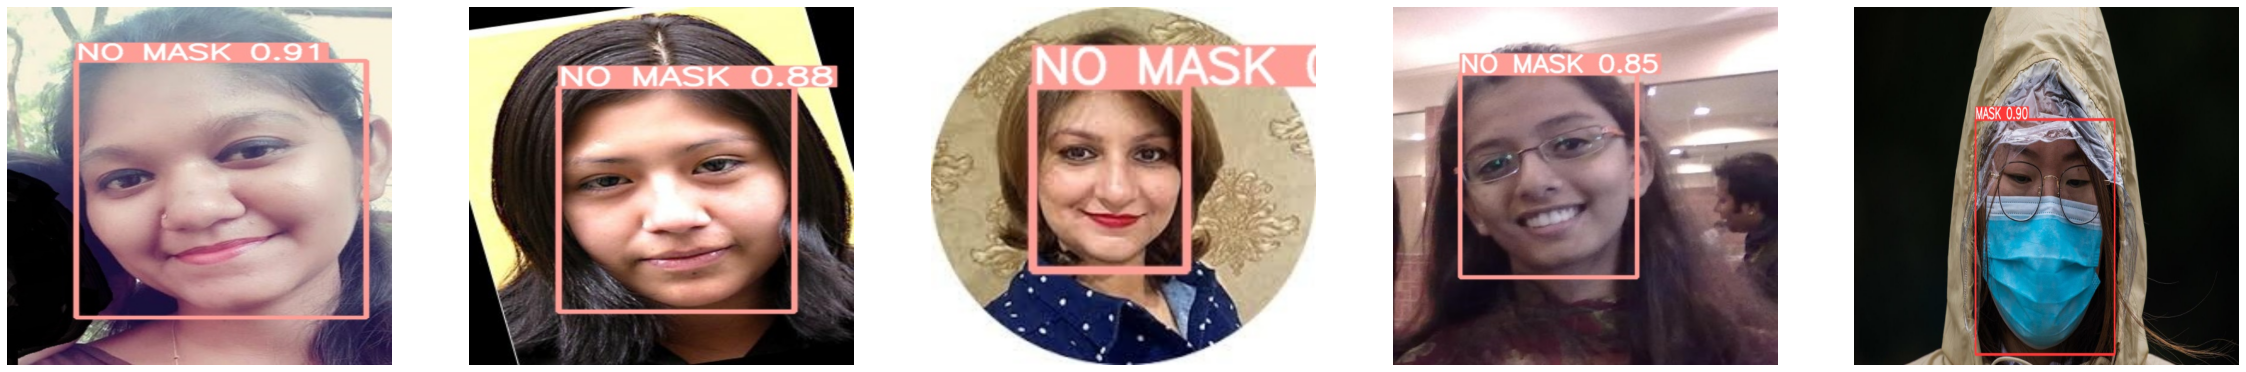

In [87]:
display_images(results, location=location, num_samples=5, resize=FIG_SIZE )